In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tqdm
import copy
from pprint import pprint

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

import gensim
from gensim.models import *
from gensim.models.fasttext import FastText
from gensim.utils import simple_preprocess
import gensim.corpora as corpora


from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import *

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nitanshjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nitanshjain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
tweets_df = pd.read_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/tweets_with_sentiment_v2.csv')
tweets_neg_df = tweets_df[tweets_df['sentiment_flair']==-1]
tweets_neg_df.head()

,tweet_id,tweet,city,year,tweets_tokens,sentiment_flair,sentiment_nltk,sentiment_flair_glove_embed_kmeans,sentiment_fast_text_embed_kmeans,sentiment_fast_text_embed_nmf_kmeans
0,0,very bad thing say that government did not med...,Mumbai,2022,"['very', 'bad', 'thing', 'say', 'that', 'gover...",-1,-1,-1,-1,1
1,1,all netas and their family should admitted onl...,Mumbai,2022,"['all', 'netas', 'and', 'their', 'family', 'sh...",-1,-1,-1,-1,1
5,5,very hygiene government veterinary hospital as...,Mumbai,2022,"['very', 'hygiene', 'government', 'veterinary'...",-1,1,-1,-1,-1
7,7,shall throw out india let take care our health...,Mumbai,2022,"['shall', 'throw', 'out', 'india', 'let', 'tak...",-1,1,-1,-1,1
9,9,not online school wild guess going south mumba...,Mumbai,2022,"['not', 'online', 'school', 'wild', 'guess', '...",-1,-1,-1,1,-1


In [10]:
tfidf = TfidfVectorizer(lowercase=False)
x_tfidf = tfidf.fit_transform(tweets_neg_df['tweet'])
x_tfidf_numpy = x_tfidf.toarray()

In [11]:
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = tweets_neg_df['tweet'].values.tolist()
data_words = list(sent_to_words(data))

In [12]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
import spacy
spacy.load('en_core_web_sm')

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [15]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [16]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.086*"understand" + 0.072*"mean" + 0.059*"hospital" + 0.040*"doctor" + '
  '0.011*"government" + 0.010*"patient" + 0.008*"get" + 0.007*"significant" + '
  '0.006*"terminal" + 0.006*"poor"'),
 (1,
  '0.068*"hospital" + 0.030*"poor" + 0.025*"doctor" + 0.021*"people" + '
  '0.018*"get" + 0.014*"treatment" + 0.014*"pay" + 0.014*"money" + '
  '0.011*"private" + 0.011*"patient"'),
 (2,
  '0.067*"hospital" + 0.020*"terminal" + 0.017*"doctor" + 0.012*"take" + '
  '0.012*"dead" + 0.011*"patient" + 0.007*"injure" + 0.007*"bad" + '
  '0.007*"report" + 0.007*"death"'),
 (3,
  '0.047*"take" + 0.045*"road" + 0.041*"action" + 0.029*"hospital" + '
  '0.016*"ambulance" + 0.014*"traffic" + 0.011*"parking" + 0.011*"police" + '
  '0.011*"vehicle" + 0.010*"park"'),
 (4,
  '0.044*"doctor" + 0.037*"hospital" + 0.014*"service" + 0.010*"bad" + '
  '0.009*"terminal" + 0.009*"come" + 0.008*"call" + 0.007*"staff" + 0.007*"go" '
  '+ 0.007*"wait"'),
 (5,
  '0.086*"guess" + 0.065*"wild" + 0.047*"hospital" 

In [17]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.38218334609741217


In [18]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [19]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# # Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
            
            pbar.update(1)
    pd.DataFrame(model_results).to_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/lda_tuning_results.csv', index=False)
    pbar.close()

496it [3:46:25, 27.39s/it]                           


<Axes: xlabel='Topics', ylabel='Coherence'>

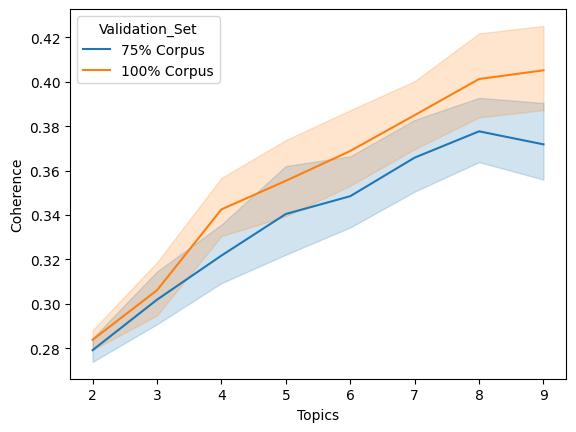

In [20]:
lda_results = pd.read_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/lda_tuning_results.csv')
sns.lineplot(x='Topics', y='Coherence', hue='Validation_Set', data=lda_results)

In [27]:
lda_results[lda_results['Coherence']==max(lda_results['Coherence'])]

,Validation_Set,Topics,Alpha,Beta,Coherence
477,100% Corpus,9,asymmetric,0.61,0.540384


In [35]:
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=500,
                                           passes=10,
                                           alpha='asymmetric',
                                           eta=0.61)

In [36]:
import pyLDAvis.gensim_models as gensimvis
import os
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, '/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.221470 -0.033154       1        1  78.790563
1     -0.080904  0.075006       2        1  15.134294
2      0.046953 -0.050405       3        1   3.773901
3      0.128162  0.004316       4        1   1.171370
4      0.127259  0.004236       5        1   1.129872, topic_info=             Term         Freq        Total Category  logprob  loglift
20       hospital  7988.000000  7988.000000  Default  30.0000  30.0000
55          death   830.000000   830.000000  Default  29.0000  29.0000
93      condition  1008.000000  1008.000000  Default  28.0000  28.0000
276          road   403.000000   403.000000  Default  27.0000  27.0000
58          guess  1453.000000  1453.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1373        plain     0.810503     7.689980   Topic5  -7.7257   2.2330
2814  reservation     0.898512    13.063269   Topic5  -7.6226   1.8062
1824         note     0.868515    47.274164   Topic5  -7.6565   0.4861
2360         lock     0.749989    17.278861   Topic5  -7.8033   1.3459
1376       simple     0.743964    25.962771   Topic5  -7.8113   0.9306

[319 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
268       1  0.630469      action
268       2  0.364786      action
268       3  0.004217      action
1406      1  0.828751    activity
1406      2  0.046042    activity
...     ...       ...         ...
65        3  0.000901        wild
287       1  0.801358        work
287       2  0.197595        work
3439      1  0.104609  wrong_side
3439      2  0.836869  wrong_side

[671 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])